## Interactive Spectral Energy distribution

The goal of this tool is to show you how physical parameters impact the observed multi-wavelength flux.<br/>
The module used here is naima (http://naima.readthedocs.io/en/latest/) a package for computation of non-thermal radiation from relativistic particle populations and Markov Chain Monte Carlo fitting.  <br/>

To install naima:

conda config --add channels astropy --add channels sherpa #to add astropy affiliated packages to conda manager
conda install naima



In [34]:
%matplotlib inline

from naima import models
from astropy import units as u
from astropy import table

from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
from ipywidgets.widgets.interaction import interact

def plotSED_data(SEDfile,label='data',color='blue'):
    print 'Reading file =', SEDfile
    SED = table.Table.read( SEDfile, hdu=1 )        
    plt.errorbar(E[index],E2flux[index],yerr=arrowfraction*E2flux[index],uplims=True,fmt="none",ecolor=color)

def plotSED_sync_ic( distance= 1 *u.kpc, We=1e47 *u.erg, e_cut = 100*u.TeV,B=10 *u.uG,
               field="CMB", index=2,N=200):
    """
    Distance needs to be in kpc
    """
    Eunits = u.eV
    E = np.logspace(-6,14.5, N) * Eunits # photon energies
    electrondist = models.ExponentialCutoffPowerLaw(
        amplitude=u.Quantity(1e36,"1/eV"), e_0= 1*Eunits, alpha=index, e_cutoff=e_cut)

    ic = models.InverseCompton( electrondist, seed_photon_fields=[field] )
    syn = models.Synchrotron(electrondist, B=B)
    ic.set_We(We, Eemin=1 * u.GeV, Eemax=100 *u.TeV)
    syn.set_We(We, Eemin=1 * u.GeV, Eemax=100 *u.TeV)
    plt.loglog(E, ic.sed(E,distance=dist ),'-', alpha=0.8,label='IC')
    plt.loglog(E, syn.sed(E,distance=dist ),'-', alpha=0.8,label='Synch')

def plotSED_pi0( distance = 1*u.kpc, rho=1* u.cm**-3,
                Wp=1e50 *u.erg, e_cut = 100*u.TeV,  index=2,N=200):
    """
    Distance needs to be in kpc and density in cm-3
    """
    
    Eunits = u.eV
    E = np.logspace(-6,14.5, N) * Eunits # photon energies
    partdist = models.ExponentialCutoffPowerLaw(
        amplitude=u.Quantity(1e36,"1/eV"), e_0= 1*Eunits, alpha=index, e_cutoff=e_cut)
    
    pi0 = models.PionDecay(partdist, nh = rho)
    pi0.set_Wp(Wp, Epmin=1 * u.GeV, Epmax=100 *u.TeV) 
    plt.loglog(E, pi0.sed(E,distance=distance ),'-', alpha=0.8,label='$\pi_{0}$ decay')
    


In [47]:

dist = 1 * u.kpc
rho = 1.0 * u.cm**-3
We = 1e47 *u.erg
Wp = 1e50 *u.erg
Ecut_p = 100 *u.TeV
Ecut_e = 100 *u.TeV
tel_dict={"Radio":[6e-6,6e-5],"X-rays":[0.5e3,1e4],"Fermi-LAT":[1e8,5e11],"Cherenkov":[1e11,5e13]}


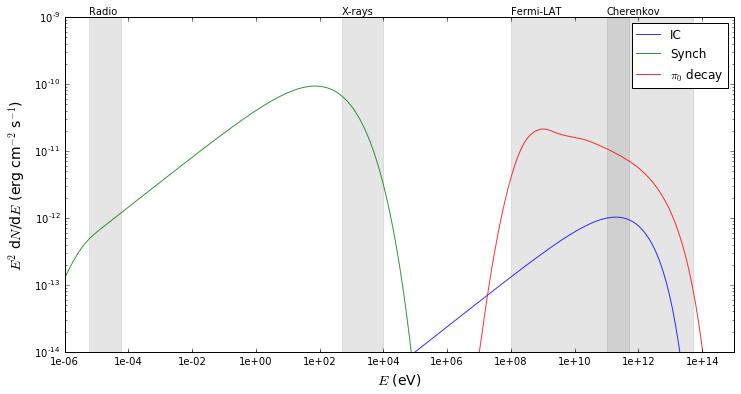

None

In [50]:
def plotSED(rho=rho,Ecut_p=Ecut_p,Ecut_e=Ecut_e,index=2,B=10):
    """
    Plot SED from an electron+proton population with Powerlaw + Exp cutoff distribution.
    Parameters:
    Index     :   Slope of the particle population
    Ecut_e/p  : Cutoff energy in TeV
    rho       : for the Pi0 decay, density of medium colliding with accelerated protons in cm-3
    B         : Magnetic field (microGauss) for synchrotron emission
    
    Notes:
    For the IC mechanism, only the CMB is assumed but naima supports other radiation field.
    """
    fig = plt.figure(figsize=(12,6))
    
    plotSED_sync_ic(distance=dist,We=1e47*u.erg, index=index,e_cut=Ecut_e*u.TeV, B=B*u.uG)
    plotSED_pi0(distance=dist,rho=rho*u.cm**-3,Wp=1e50*u.erg, e_cut=Ecut_p*u.TeV,  index=index)
#    plotSED_data()

    ymax=1e-9
    plt.ylim(1e-14,ymax)
    plt.xlim(1e-6,1e15)
    size=14
    plt.ylabel(r'$E^2$ d$N$/d$E$ (erg cm$^{-2}$ s$^{-1}$)',fontsize=size)
    plt.xlabel(r'$E$ (eV)',fontsize=size)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.e') )
    for tel in telescopes:
        ax.axvspan(tel_dict[tel][0],tel_dict[tel][1],alpha=0.2,color='grey')
        plt.text(tel_dict[tel][0],ymax*1.1,tel)
    
    plt.legend(numpoints=1)
    plt.show()


interact(plotSED,Ecut_p=(1e1,1e2,1e1),Ecut_e=(1e1,1e2,1e1),index=(1.5,2.5,0.25),
         rho=(0.5,2,0.5), B=(10,40,5) )